Super Trend is a well-known indicator used by many investors due to its intuitive signal. Plus, it is common for cryptocurrency investors to incorporate this particular indicator into their automated trading systems.

There are so many python code for the Super Trend but, contrariwise, it is so rare in R, therefore I made this indicator using R code

Set up the required packages and set parameters

In [ ]:
install.packages('pacman')

In [4]:
pacman::p_load(tidyr, dplyr, tidyquant,plotly)

set.seed(1234)
ticker = "AAPL"
start = "2021-01-01" ; end = "2023-01-01"
multiplier = 3; n=10 #


tidyquant installed



In [11]:
"%+%" = paste0

I utilized the price data of AAPL to calculate important values like TR and ATR.

The following values have been calculated using the method outlined below:Those values are calculated as below :

* **TR** = Max(high - low, high - close, close - low)
* **ATR** = Simple Moving Average of TR (default is 10)
* **Basic Upper Bands** = (High + low)/2 + Multiplier * ATR
* **Basic Lower Bands** = (High + low)/2 - Multiplier * ATR

* **Final Upper Bands** = **If** "*Basic Upper Bands(t) < Final Upper Bands(t-1)*" or "*Close(t-1) > Final Upper Bands(t-1)*", *Basic Upper Bands(t)*, **else**  *Final Upper Bands(t-1)*
* **Final Lower Bands** = **If** "*Basic Lower Bands(t) > Final Lower Bands(t-1)*" or "*Close(t-1) < Final Lower Bands(t-1)*", *Basic Lower Bands(t)*, **else**  *Final Lower Bands(t-1)*


In [8]:
df = tq_get(
  ticker,
  from = start,
  to = end
) %>%
  mutate(
    TR = if_else(row_number()==1,0,pmax(high-low,high-close,close-low)),
    ATR = SMA(TR,n),
    ATR = if_else(row_number()==n,NA,ATR),
    BasicUpperBands = (high+low)/2+multiplier*ATR,
    BasicLowerBands = (high+low)/2-multiplier*ATR,
    FinalUpperBands = if_else(row_number()==n+1,BasicUpperBands,NA),
    FinalLowerBands = if_else(row_number()==n+1,BasicLowerBands,NA),
    Trend = if_else(row_number() == n+1, BasicUpperBands, NA)
  )

  for(i in (n+2):nrow(df)){
  df$FinalUpperBands[i] = ifelse(df$BasicUpperBands[i] < df$FinalUpperBands[i-1] | df$close[i-1] > df$FinalUpperBands[i-1],
                                 df$BasicUpperBands[i],
                                 df$FinalUpperBands[i-1])

  df$FinalLowerBands[i] = ifelse(df$BasicLowerBands[i] > df$FinalLowerBands[i-1] | df$close[i-1] < df$FinalLowerBands[i-1],
                                 df$BasicLowerBands[i],
                                 df$FinalLowerBands[i-1])


  df$Trend[i] = ifelse((df$Trend[i-1] == df$FinalUpperBands[i-1]) & (df$close[i] <= df$FinalUpperBands[i]),
                       df$FinalUpperBands[i],

                       ifelse((df$Trend[i-1] == df$FinalUpperBands[i-1]) & (df$close[i] >= df$FinalUpperBands[i]),
                              df$FinalLowerBands[i],

                              ifelse((df$Trend[i-1] == df$FinalLowerBands[i-1]) & (df$close[i] >= df$FinalLowerBands[i]),
                                     df$FinalLowerBands[i],

                                     ifelse((df$Trend[i-1] == df$FinalLowerBands[i-1]) & (df$close[i] <= df$FinalLowerBands[i]),
                                            df$FinalUpperBands[i],NA

                                     ))))

}

In [9]:
tail(df)

symbol,date,open,high,low,close,volume,adjusted,TR,ATR,BasicUpperBands,BasicLowerBands,FinalUpperBands,FinalLowerBands,Trend
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAPL,2022-12-22,134.35,134.56,130.30,132.23,77852100,131.3274,4.259995,4.459000,145.807,119.053,144.188,122.085,144.188
AAPL,2022-12-23,130.92,132.42,129.64,131.86,63814900,130.9599,2.779999,4.269998,143.840,118.220,143.840,122.085,143.840
AAPL,2022-12-27,131.38,131.41,128.72,130.03,69007800,129.1424,2.690002,4.194998,142.650,117.480,142.650,122.085,142.650
AAPL,2022-12-28,129.67,131.03,125.87,126.04,85438400,125.1797,5.159996,4.137998,140.864,116.036,140.864,122.085,140.864
AAPL,2022-12-29,127.99,130.48,127.73,129.61,75703700,128.7253,2.749992,3.862997,140.694,117.516,140.694,122.085,140.694
AAPL,2022-12-30,128.41,129.95,127.43,129.93,77034200,129.0431,2.519997,3.537997,139.304,118.076,139.304,122.085,139.304


If the "Trend" value is greater than the "Close" value, it indicates a "SELL" signal. Conversely, if the "Close" value is greater than the "Trend" value, it indicates a "BUY" signal.

In [12]:
df = df %>%
  mutate(

    signal = if_else(close < Trend,
                     "SELL",
                     "BUY"),
    sigg = if_else(signal != lag(signal), signal %+% " Signal",NA),
    neg = if_else(signal == "SELL",
                  Trend,NA)
  )

I suggest using visualization to obtain intuitive trading signals. Visualization is not required but the super trend indicator stands out in visualization.

In [ ]:
ann = list(
  x = df$date[which(!is.na(df$sigg))],
  y = df$Trend[which(!is.na(df$sigg))],
  text = df$sigg[which(!is.na(df$sigg))],
  xref = "x",
  yref = "y",
  showarrow = TRUE,
  arrowhead = 7,
  ax = 10,
  ay = -40
)

df %>%
  plot_ly(
    x=~date,
    open = ~open,
    high = ~high,
    low = ~low,
    close = ~close,
    type= "ohlc",
    name = "OHLC"
    ) %>%
  add_lines(
    x=~date,
    y=~Trend,
    color = I("#33c483"),
    name = "BUY"
  ) %>%
  add_lines(
    x = ~date,
    y = ~neg,
    color = I("#c4338f"),
    name = "SELL"
  ) %>%
  layout(
    annotations = ann
  )

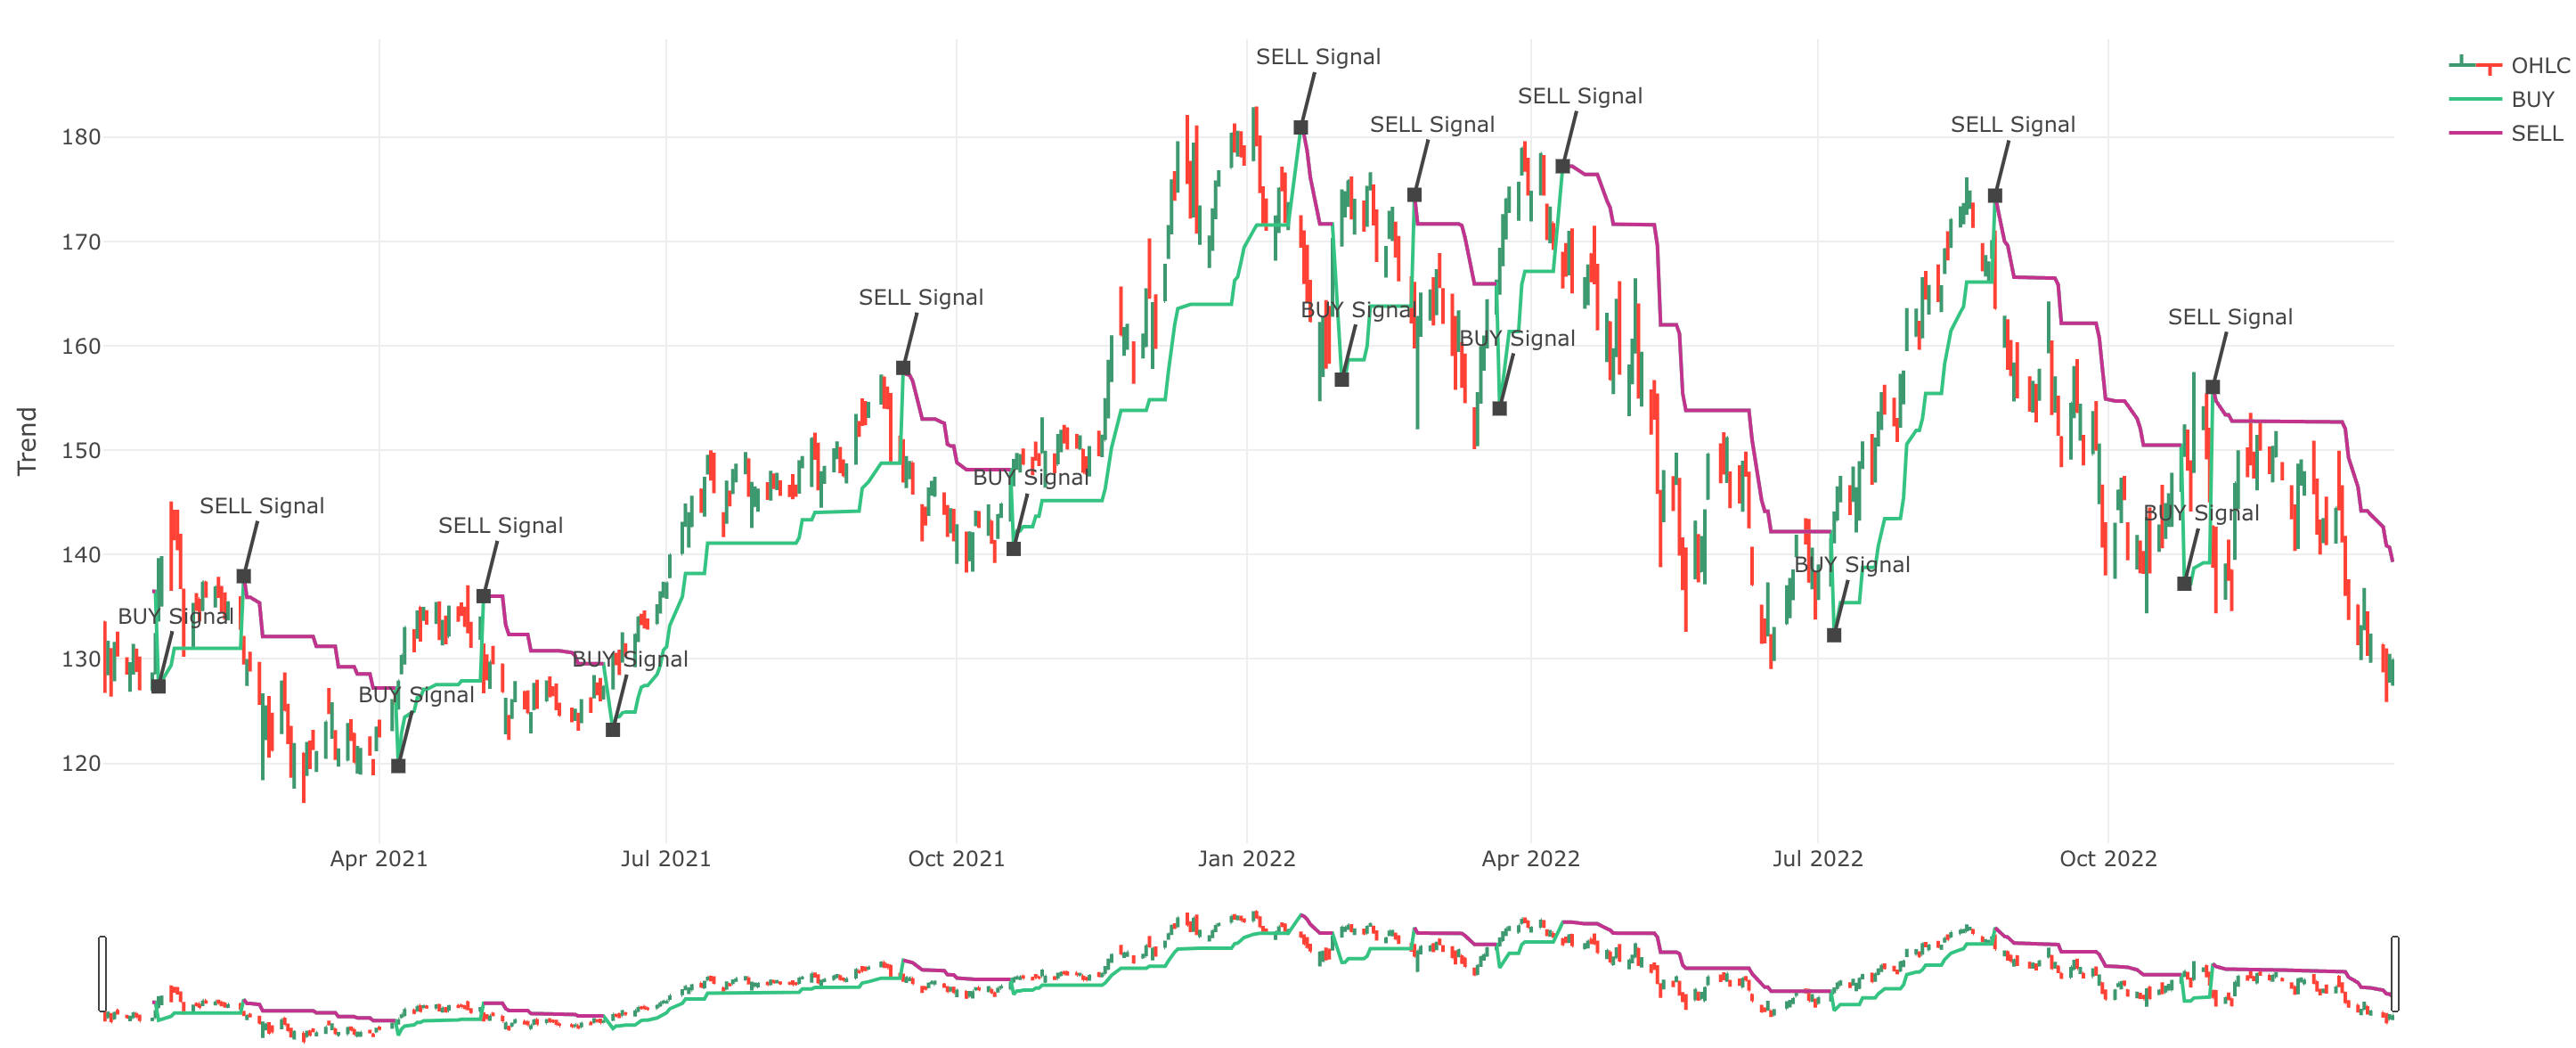